# Home Credit Default Risk #
### Random Forest ###

## Packages ##

In [145]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os

## Loading Data ##

In [14]:
print(os.listdir())

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [190]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
descriptions = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'latin-1')

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis ##

### Shape of Data Sets ###

In [66]:
print(app_train.shape)
print(app_test.shape)

(307511, 122)
(48744, 121)


### Checking for Missingness ###

In [70]:
missing_pcg = app_train.isnull().sum()/len(app_train)
missing_pcg[missing_pcg > 0.5].sort_values(ascending = False)

COMMONAREA_AVG              0.698723
COMMONAREA_MEDI             0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MODE               0.593767
LANDAREA_MEDI               0.593767
LANDAREA_AVG                0.593767
BASEMENTAREA_AVG            0.585160
BASEMENTAREA_MEDI           0.585160
BASEMENTAREA_MODE           0.585160
EXT_SOURCE_1                0.563811
NONLIVINGAREA_AVG           0.551792
NONLIVINGAREA_MODE          0.551792
NONLIVINGAREA_MEDI          0.551792
E

Many columns have very high levels of missingness. Many of these may be important. I will impute values when needed later.

### One Hot Encoding ###

#### Checking Number of Columns for Each Type ####

In [61]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

#### Checking Names of 'Object' Types ####

In [59]:
app_train.dtypes[app_train.dtypes == 'object'].index

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

#### Adding Dummy Variables ####

In [191]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

app_TARGET = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = app_TARGET

print(app_train.shape)
print(app_test.shape)

(307511, 243)
(48744, 242)


### Checking Distributions of Non-Binary Variables ###

In [112]:
train_describe = app_train.describe().T[['mean', 'std', 'min', '50%', 'max']]
train_describe = train_describe[(train_describe['min'] != 0) | (train_describe['max'] != 1)]
train_describe

,mean,std,min,50%,max
SK_ID_CURR,278180.518577,102790.175348,1.000020e+05,278202.000000,4.562550e+05
CNT_CHILDREN,0.417052,0.722121,0.000000e+00,0.000000,1.900000e+01
AMT_INCOME_TOTAL,168797.919297,237123.146279,2.565000e+04,147150.000000,1.170000e+08
AMT_CREDIT,599025.999706,402490.776996,4.500000e+04,513531.000000,4.050000e+06
AMT_ANNUITY,27108.573909,14493.737315,1.615500e+03,24903.000000,2.580255e+05
AMT_GOODS_PRICE,538396.207429,369446.460540,4.050000e+04,450000.000000,4.050000e+06
REGION_POPULATION_RELATIVE,0.020868,0.013831,2.900000e-04,0.018850,7.250800e-02
DAYS_BIRTH,-16036.995067,4363.988632,-2.522900e+04,-15750.000000,-7.489000e+03
DAYS_EMPLOYED,63815.045904,141275.766519,-1.791200e+04,-1213.000000,3.652430e+05
DAYS_REGISTRATION,-4986.120328,3522.886321,-2.467200e+04,-4504.000000,0.000000e+00


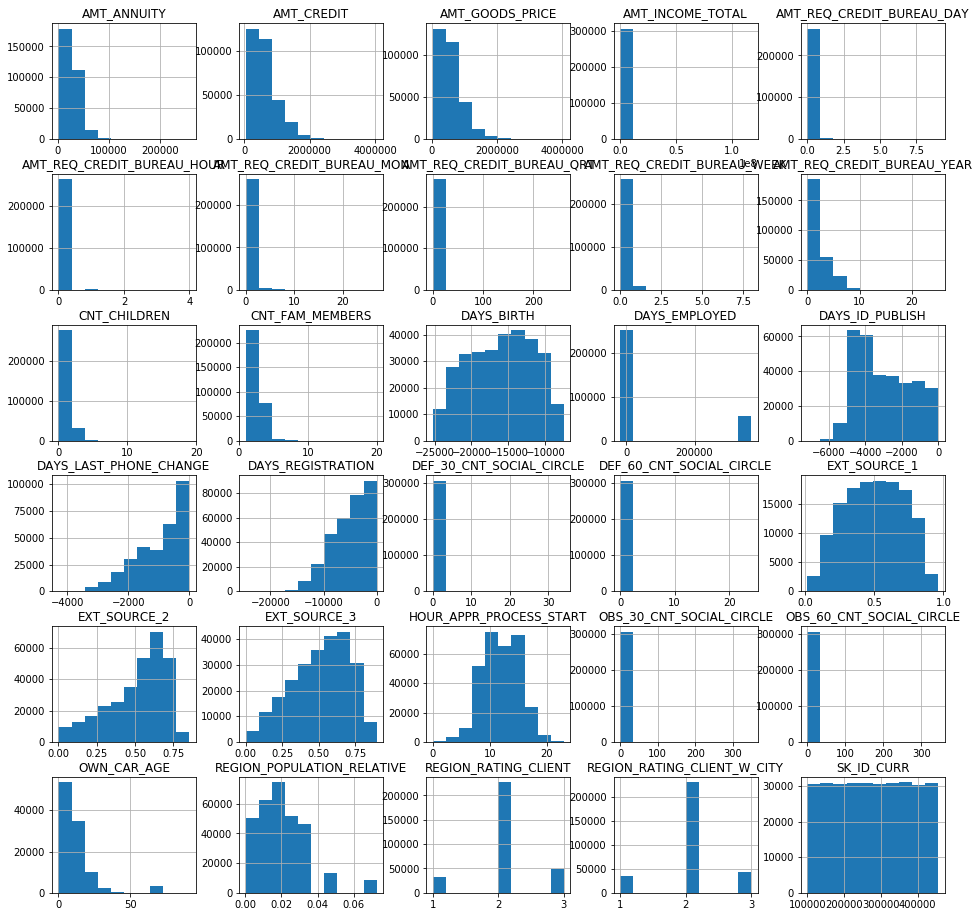

In [136]:
train_hists = app_train[train_describe.index].hist(figsize = (16,16))

One note is that 'DAYS_EMPLOYED' appears to have an error. Values are either negative (corresponding to the number of days since obtaining most recent job) or are positive (1000 years). I'm assuming this means currently unemployed.

In [214]:
print(app_train[app_train['DAYS_EMPLOYED'] == 365243]['TARGET'].mean()) # abnormal 'DAYS_EMPLOYED'
print(app_train[app_train['DAYS_EMPLOYED'] != 365243]['TARGET'].mean()) # typical 'DAYS_EMPLOYED'

0.05399646043269404
0.0865997453765215


The observations with the abnormal 'DAYS_EMPLOYED' tended to default less. As mentioned in another kernel, because it appears to be very relevant whether or not the value is abnormal or not, a new column will be created to indicate whether 'DAYS_EMPLOYED' was abornmal. The abnormal values will then be replaced with missing values.

In [216]:
app_train['DAYS_EMPLOYED_ABNORMAL'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_test['DAYS_EMPLOYED_ABNORMAL'] = app_test["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### Analyzing Pairwise Correlations of Variables Most Correlated with TARGET ###

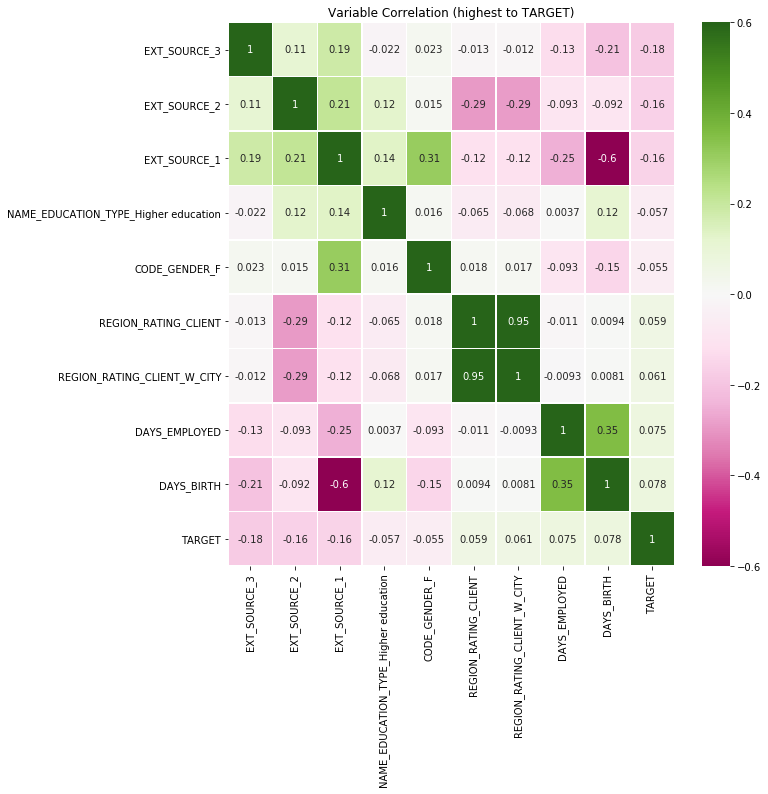

In [217]:
train_neg_corr = pd.DataFrame(app_train.corr()['TARGET'].sort_values().head())
train_pos_corr = pd.DataFrame(app_train.corr()['TARGET'].sort_values().tail())
train_most_corr = train_neg_corr.append(train_pos_corr)

fig, ax = plt.subplots(figsize=(10,10))
corr = app_train[train_most_corr.index].corr()
corr_heatmap = sns.heatmap(corr, linewidths = .5, annot = True, vmin = -0.6, vmax = 0.6, cmap="PiYG")
corr_heatmap.set_title('Variable Correlation (highest to TARGET)')
plt.show()

#### Dropping Variables With Extremely High Pairwise Correlation ####

In [188]:
app_train = app_train.drop('REGION_RATING_CLIENT_W_CITY', axis = 1)
app_test = app_test.drop('REGION_RATING_CLIENT_W_CITY', axis = 1)

## Feature Engineering ##

### Combining 'train' and 'test' Sets ###

In [399]:
app_all = pd.concat([app_train, app_test], axis = 0, join = "outer", ignore_index = True, sort = False)
app_all = app_all.sort_values(by = ['SK_ID_CURR'])
app_all = app_all.set_index('SK_ID_CURR')

### Creating Features from 'app_{train|test}' Set ###

In [400]:
app_all['CRED_INC'] = app_all['AMT_CREDIT'] / app_all['AMT_INCOME_TOTAL']
app_all['ANN_INC'] = app_all['AMT_ANNUITY'] / app_all['AMT_INCOME_TOTAL']
app_all['ANN_CRED'] = app_all['AMT_ANNUITY'] / app_all['AMT_CREDIT']
app_all['EMP_BIRTH'] = app_all['DAYS_EMPLOYED'] / app_all['DAYS_BIRTH']
app_all[['CRED_INC', 'ANN_INC', 'ANN_CRED', 'EMP_BIRTH']] = app_all[['CRED_INC', 'ANN_INC', 'ANN_CRED', 'EMP_BIRTH']].fillna(0)

### Pulling Features From 'bureau' and 'credit_card_balance' Sets ###

In [401]:
bureau = pd.read_csv('bureau.csv')

CREDIT_DAY_OVERDUE = bureau.groupby(['SK_ID_CURR'])['CREDIT_DAY_OVERDUE'].mean()
AMT_CREDIT_MAX_OVERDUE = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_MAX_OVERDUE'].mean()
AMT_CREDIT_SUM_DEBT = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].mean()
AMT_CREDIT_SUM_LIMIT = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM_LIMIT'].mean()
AMT_CREDIT_SUM_OVERDUE = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].mean()
SUM_MAX = AMT_CREDIT_SUM_OVERDUE / AMT_CREDIT_MAX_OVERDUE

In [402]:
cc_balance = pd.read_csv('credit_card_balance.csv')

AMT_BALANCE = cc_balance.groupby(['SK_ID_CURR'])['AMT_BALANCE'].mean()
AMT_CREDIT_LIMIT_ACTUAL = cc_balance.groupby(['SK_ID_CURR'])['AMT_CREDIT_LIMIT_ACTUAL'].mean()
BAL_LIMIT = AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL
AMT_PAYMENT_TOTAL_CURRENT = cc_balance.groupby(['SK_ID_CURR'])['AMT_PAYMENT_TOTAL_CURRENT'].mean()
TOTAL_BAL = AMT_PAYMENT_TOTAL_CURRENT / AMT_BALANCE

### Merging Pulled Features ###

In [431]:
new_feats = [CREDIT_DAY_OVERDUE, AMT_CREDIT_MAX_OVERDUE, AMT_CREDIT_SUM_DEBT, 
             AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, SUM_MAX, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, BAL_LIMIT, 
             AMT_PAYMENT_TOTAL_CURRENT, TOTAL_BAL]

new_feats_df = pd.DataFrame(new_feats).T
new_feats_df = new_feats_df.rename(index=str, columns = {"Unnamed 0": "SUM_MAX", "Unnamed 1": "BAL_LIMIT", "Unnamed 2": 
                                                         "TOTAL_BAL"})

new_feats_df = new_feats_df.fillna(0)
new_feats_df = new_feats_df.replace(np.inf, 1)

new_feats_df = new_feats_df.reset_index()
new_feats_df = new_feats_df.astype(dtype = {'SK_ID_CURR': 'int64'})
new_feats_df = new_feats_df.set_index('SK_ID_CURR')

### Combining Pulled Features with 'app_{train|test}' Set ###

In [439]:
app_all = app_all.join(new_feats_df)

In [452]:
all_new_feats = app_all[['CRED_INC', 'ANN_INC', 'ANN_CRED', 'EMP_BIRTH', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 
                         'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'SUM_MAX', 'AMT_BALANCE', 
                         'AMT_CREDIT_LIMIT_ACTUAL', 'BAL_LIMIT', 'AMT_PAYMENT_TOTAL_CURRENT', 'TOTAL_BAL', 'TARGET']]

### Checking for Strong Pairwise Correlation with New Features ###

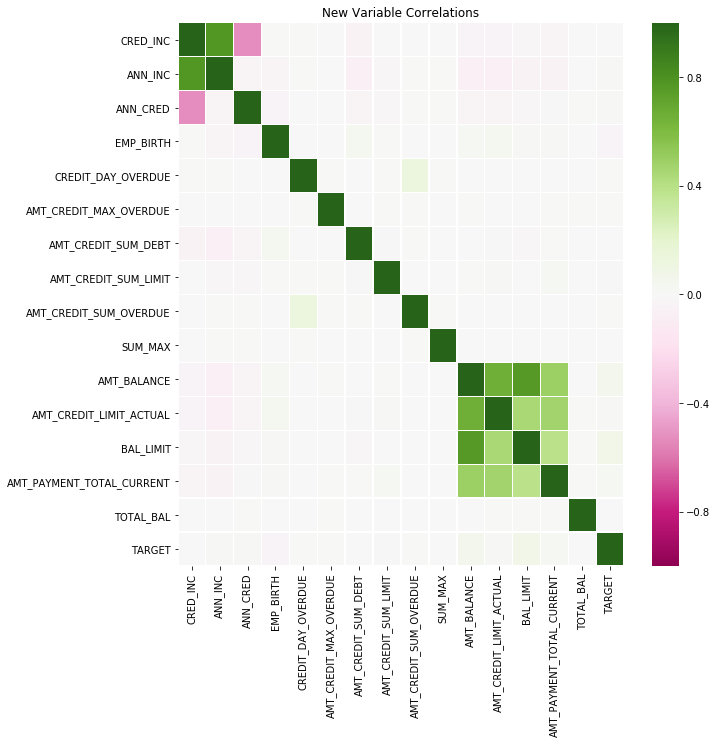

In [455]:
fig, ax = plt.subplots(figsize=(10,10))
corr = all_new_feats.corr()
corr_heatmap = sns.heatmap(corr, linewidths = .5, vmin = -1, vmax = 1, cmap="PiYG")
corr_heatmap.set_title('New Variable Correlations')
plt.show()

It does not appear that there are any extreme pairwise correlations that need removal.

## Running Random Forest ##

### Splitting Data Back into Train & Test Sets ###

In [491]:
eng_app_train = app_all[-app_all['TARGET'].isna()]
eng_app_test = app_all[app_all['TARGET'].isna()].drop('TARGET', axis = 1)

In [492]:
train = eng_app_train.drop('TARGET', axis = 1)
train_features = list(train.columns)

test = eng_app_test.copy()

### Imputing Missing Values with Median ###

In [493]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = 'median')
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Training Data & Obtaining Predictions ###

In [496]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
random_forest.fit(train, app_TARGET)
predictions = random_forest.predict_proba(test)[:, 1]

### Creating Submission File ###

In [507]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.to_csv('predictions.csv', index = False)

C:\Users\Phoenix\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [508]:
submit

,SK_ID_CURR,TARGET
0,100001,0.01
1,100005,0.10
2,100013,0.03
3,100028,0.05
4,100038,0.04
5,100042,0.06
6,100057,0.01
7,100065,0.05
8,100066,0.04
9,100067,0.16
